In [1]:
%matplotlib inline

import gc
import os
import sys
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns
from scipy.stats import mode
import pickle

import textract
import docx2txt
import PyPDF2
from PyPDF2 import PdfFileReader

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score

from lightgbm import LGBMClassifier, LGBMRegressor, log_evaluation
from lightgbm import early_stopping

from transformers import AutoTokenizer, AutoModel
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from simpletransformers.language_representation import RepresentationModel

target = 'class'

In [2]:
dtrain = pd.read_csv(
    '../input/classes.csv'
)
dtrain

,file,class
0,5908cb5da047d6c9e6dfea6337fb3189.docx,Договоры для акселератора/Договоры поставки
1,14711e4fc8e56f0c75856c8837ec04cb.docx,Договоры для акселератора/Договоры поставки
2,7eb67b5aecf3f3190aab0a5f8ea32172.docx,Договоры для акселератора/Договоры поставки
3,b40a9d048b199d5f4db62a6a2335f2a0.pdf,Договоры для акселератора/Договоры поставки
4,84fec112d02288861e7af59f468131fb.docx,Договоры для акселератора/Договоры поставки
...,...,...
115,f57fe87f15a6dee2b17e804421be63b5.pdf,Договоры для акселератора/Договоры купли-продажи
116,1ea8809d696a4bd6a2076fbc6fd28c23.docx,Договоры для акселератора/Договоры купли-продажи
117,57962abd8dbe0ce0c7056896ee4501f1.docx,Договоры для акселератора/Договоры купли-продажи
118,2c81df29db63aebf495106881a52188f.docx,Договоры для акселератора/Договоры купли-продажи


In [3]:
for u in sorted(dtrain[target].unique()):
    print(u, dtrain[dtrain[target] == u].shape[0])

Договоры для акселератора/Договоры аренды 23
Договоры для акселератора/Договоры купли-продажи 23
Договоры для акселератора/Договоры оказания услуг 32
Договоры для акселератора/Договоры подряда 21
Договоры для акселератора/Договоры поставки 21


In [4]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
dtrain[target] = le.fit_transform(dtrain[target].values)

In [5]:
for u in sorted(dtrain[target].unique()):
    print(u, dtrain[dtrain[target] == u].shape[0])

0 23
1 23
2 32
3 21
4 21


In [6]:
dtrain['text'] = np.nan

for i in dtrain.index:
    file = dtrain.loc[i, 'file']
    if '.docx' in file:
        path = "../input/docs/" + file
        result = docx2txt.process(path)
        dtrain.loc[i, 'text'] =  result
        
    elif '.pdf' in file:
        result = ''
        path = "../input/docs/" + file
        with open(path, "rb") as filehandle:  
            try:
                pdf = PdfFileReader(filehandle)
                info = pdf.getDocumentInfo()
                pages = pdf.getNumPages()   
                #print (info)
                #print ("number of pages: %i" % pages)   
                for y in range(pages):
                    page = pdf.getPage(y)
                    page = page.extractText()
                    result += page
            except:
                print(file)
        
        dtrain.loc[i, 'text'] =  result

19e2becdb0f10e1c16a5a2460f3a84a2.pdf
81a64023bdb74032827385d43181ea3a.pdf


In [7]:
print(dtrain.shape)
dtrain = dtrain[dtrain['text'] == dtrain['text']]
print(dtrain.shape)

(120, 3)
(116, 3)


In [8]:
dtrain

,file,class,text
0,5908cb5da047d6c9e6dfea6337fb3189.docx,4,1\n\n\n\n\t\t\t\tДОГОВОР \n\n\n\nг. Москва\n\n...
1,14711e4fc8e56f0c75856c8837ec04cb.docx,4,"Договор №______________\n\n\n\n\n\n Дата, мест..."
2,7eb67b5aecf3f3190aab0a5f8ea32172.docx,4,ДОГОВОР ЗАКУПКИ № __________/\n\n\n\nг.\t\t\t\...
3,b40a9d048b199d5f4db62a6a2335f2a0.pdf,4,\n ДОГОВОР ПОСТАВКИ № 1 г. Москва «1...
4,84fec112d02288861e7af59f468131fb.docx,4,Договор № {НомерДокумента}\n\n\n\n{ДатаДокуме...
...,...,...,...
115,f57fe87f15a6dee2b17e804421be63b5.pdf,1,Страница 1 из 8 \n \nДОГОВОР КУПЛИ -ПРОДАЖИ …...
116,1ea8809d696a4bd6a2076fbc6fd28c23.docx,1,ДОГОВОР\n\n\n\nг. Москва\n\n«_____» __________...
117,57962abd8dbe0ce0c7056896ee4501f1.docx,1,ПРЕДВАРИТЕЛЬНЫЙ ДОГОВОР\n\n\n\nг. Москва\n\n«_...
118,2c81df29db63aebf495106881a52188f.docx,1,ДОГОВОР\n\n№ __\n\n\n\nг.________________\t\t\...


In [9]:
import re
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

morph = MorphAnalyzer()
stop_words = stopwords.words('russian')

def clear_text(text):
    
    text = " ".join((re.sub(r'[^-а-яА-ЯёЁ]', ' ', text).split())).lower()    
    
    out = []
    for token in text.split():
        token = morph.normal_forms(token)[0]
        out.append(token)
    
    text = " ".join(out)
    text = " ".join([word for word in text.split() if word not in stop_words])
    
    return text

dtrain['text'] = dtrain['text'].apply(lambda x: clear_text(x))

C:\Temp\ipykernel_11992\2168239244.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtrain['text'] = dtrain['text'].apply(lambda x: clear_text(x))


In [10]:
print(dtrain.shape)
dtrain = dtrain[dtrain['text'] == dtrain['text']]
dtrain = dtrain[dtrain['text'] != '']
dtrain = dtrain[dtrain['text'] != ' ']
dtrain = dtrain[dtrain['text'] != '  ']
print(dtrain.shape)

(116, 3)
(114, 3)


In [11]:
dtrain['text'].sample(10)

119    договор г омск г муниципальный образование гор...
54     договор номер г санкт-петербург февраль год об...
67     договор г г наименование организация предприят...
72     договор г г именовать дальнейший подрядчик лиц...
8      договор поставка поставка указываться предмет ...
41     договор г москва год гр рф год рождение фамили...
7      приложение приказ г договор реализация продукц...
63     договор г рязань г далее именовать заказчик ли...
91     договор г г лицо директор действовать основани...
96     договор г год основание протокол результат тор...
Name: text, dtype: object

In [12]:
print(dtrain.shape)
dtrain = dtrain[dtrain['text'] == dtrain['text']]
dtrain = dtrain[dtrain['text'] != '']
dtrain = dtrain[dtrain['text'] != ' ']
dtrain = dtrain[dtrain['text'] != '  ']
print(dtrain.shape)

(114, 3)
(114, 3)


In [13]:
# # "sberbank-ai/sbert_large_mt_nlu_ru"

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
import torch

def embed(data, cls = True, length = 256, test = False):
    
    col = 2
    
    emb = np.zeros([1, 312])
    batch_size = 2

    for index in range(0, len(data), batch_size):

        batch = list(data.iloc[index: min(index + batch_size, data.shape[0]), col])
        
        encoded_input = tokenizer(
            batch, 
            padding = True, 
            truncation = True, 
            return_tensors = 'pt', 
            max_length = length
        )

        with torch.no_grad():
            model_output = model(**{k: v.to(model.device) for k, v in encoded_input.items()})
        if cls:
            embeddings = model_output.last_hidden_state[:, 0, :]
        else:
            embeddings = model_output.pooler_output
            
        embeddings = torch.nn.functional.normalize(embeddings)
        emb = np.vstack((emb, embeddings))

    return emb[1:]

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    dtrain, dtrain[target], 
    test_size = 0.1, 
    random_state = 0, 
    stratify = dtrain[target]
)

In [16]:
%%time
X_train = pd.DataFrame(embed(X_train, test = False, cls = False))
use = ['x_' + str(f) for f in range(X_train.shape[1])]
X_train.columns = use
print(X_train.shape)

(102, 312)
Wall time: 8.19 s


In [17]:
%%time
X_val = pd.DataFrame(embed(X_val, test = False, cls = False))
X_val.columns = use
print(X_val.shape)

(12, 312)
Wall time: 1.11 s


In [18]:
model = LogisticRegression(C = 1)
model.fit(X_train, y_train)

LogisticRegression(C=1)

In [19]:
y_pred = model.predict(X_val)
f1_score(y_val, y_pred, average = 'weighted')

0.7351190476190474

In [20]:
def get_score():
    models = []
    SEEDS = 1
    
    params = {
        'max_depth': 5,
        'num_leaves': 31,
        'subsample': 0.98,
        'subsample_freq': 3,
        'colsample_bytree': 0.98,
        'reg_alpha': 0.01,
        'reg_lambda': 0.1,        
        'n_estimators': 1000,
        'random_state': 0,
    }
    for seed in range(SEEDS):
        params['random_state'] = seed
        model = LGBMClassifier(**params)
        model.fit(
            X_train,
            y_train,
            eval_set = (X_val, y_val),
            callbacks = [early_stopping(500, verbose = 100), log_evaluation(100)],
            #eval_metric = lgb_metric
        )
        models.append(model)
    return models, dict(model.best_score_)['valid_0']['multi_logloss']

In [21]:
models, best = get_score()
best

Training until validation scores don't improve for 500 rounds
[100]	valid_0's multi_logloss: 0.759461
[200]	valid_0's multi_logloss: 0.87008
[300]	valid_0's multi_logloss: 0.891335
[400]	valid_0's multi_logloss: 0.893514
[500]	valid_0's multi_logloss: 0.893956
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.602137


0.6021373262491948

In [22]:
y_pred = models[0].predict(X_val)
f1_score(y_val, y_pred, average = 'weighted')

0.6809523809523809

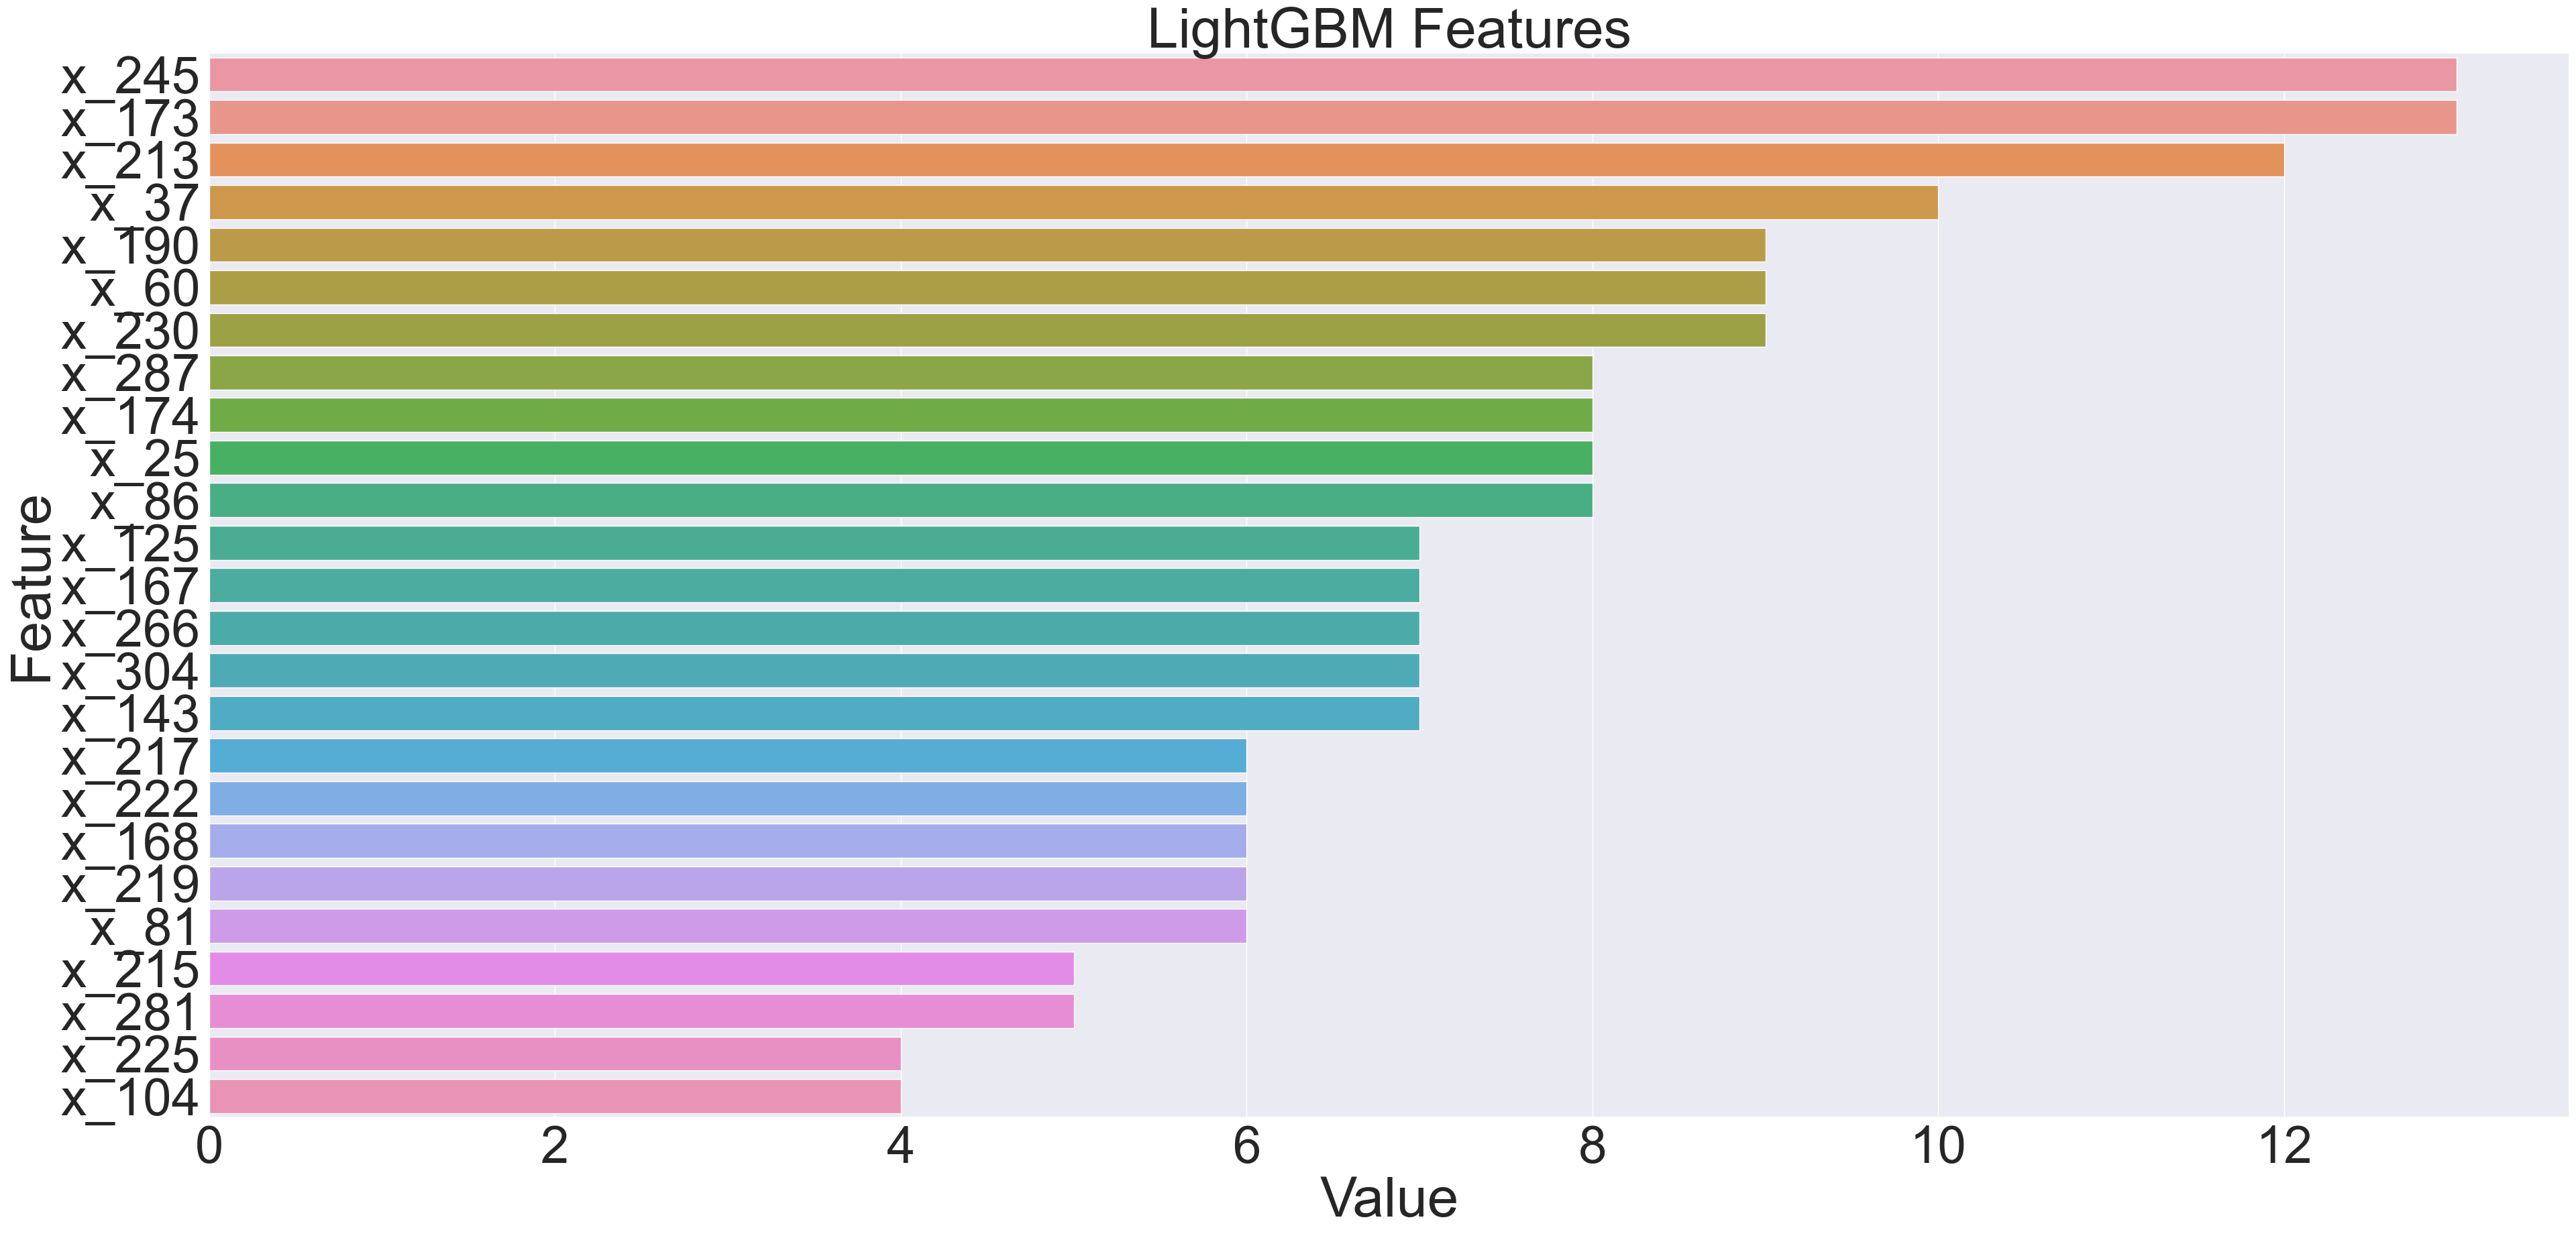

In [25]:
import matplotlib.pyplot as plt

def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_, 'Feature':X.columns})
    plt.figure(figsize = fig_size)
    sns.set(font_scale = 5)
    
    sns.barplot(
        x = "Value", 
        y = "Feature", 
        data = feature_imp.sort_values(by = "Value", ascending = False)[0:num]
    )
    
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
    
plotImp(models[0], X_train, num = 25)    

In [26]:
weight = list(len(dtrain[target]) / (5 * np.bincount(dtrain[target])))
weight

[0.991304347826087,
 0.991304347826087,
 0.8444444444444444,
 1.0857142857142856,
 1.14]

In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    dtrain, dtrain[target], 
    test_size = 0.1, 
    random_state = 0, 
    stratify = dtrain[target]
)

In [28]:
# зададим конфигурацию модели - вос
model_new = ClassificationModel(
    model_type = 'bert',
    model_name = "cointegrated/rubert-tiny2", 
    tokenizer_name = "cointegrated/rubert-tiny2", 
    num_labels = len(dtrain[target].value_counts()),  # 5 категорий
    weight = weight, # посчитанные выше веса
    use_cuda = False,
    args = {
        "reprocess_input_data": True, 
        "overwrite_output_dir": True, 
        'num_train_epochs': 15, # 1 эпоха
        'manual_seed': 42, 
        'optimizer': 'AdamW',
        'evaluate_during_training': False, 
        'weight_decay': 0,
        'scheduler': 'linear_schedule_with_warmup', 
        'sliding_window': False,
        'config': {"output_hidden_states": True} # делаем возможность использования дообученной модели как энкодера
    }
)

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not 

In [29]:
X_train = X_train[['text', 'class']]
X_train.head(3)

,text,class
93,договор г москва год гр рф год рождение фамили...,0
37,договор цкп г москва г федеральный государстве...,2
99,договор купля-про дажа ранспорый тнога сре дст...,1


In [30]:
%%time
model_new.train_model(X_train)

C:\Users\Vlad\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Running Epoch 0 of 15:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 1 of 15:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 2 of 15:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 3 of 15:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 4 of 15:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 5 of 15:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 6 of 15:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 7 of 15:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 8 of 15:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 9 of 15:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 10 of 15:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 11 of 15:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 12 of 15:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 13 of 15:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 14 of 15:   0%|          | 0/13 [00:00<?, ?it/s]

Wall time: 4min 13s


(195, 0.9803726552388607)

In [31]:
X_val = X_val[['text', 'class']]
X_val.head(3)

,text,class
95,договор аренда транспортный средство экипаж до...,0
74,договор аренда нежилой помещение договор г г д...,0
33,утвердить приказ генеральный директор ооо рено...,2


In [32]:
result, model_outputs, wrong_predictions = model_new.eval_model(X_val)
predictions, raw_outputs, embs, smth_else = model_new.predict(list(X_val['text']))

C:\Users\Vlad\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]

In [33]:
sc = f1_score(y_val, predictions, average = 'weighted')
sc

0.8174603174603173